### Script to generate summaries using chunking based BERT_BART method


In [1]:
# !pip install gensim

In [2]:
dataset = "IN-Abs"
output_path = ""

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
from BART_utilities import *
# sys.path.insert(0, '../')
import transformers
import pandas as pd
import numpy as np
import glob
import nltk
import torch
from utilities import *
import math
import random
import re
import argparse
import os
import matplotlib.pyplot as plt


In [5]:

from transformers import BartTokenizer, BartForConditionalGeneration

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import Counter

In [6]:
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, BartConfig
from transformers import pipeline

In [7]:
#Reading the test documents
# names, data_source, data_summary = get_summary_data(dataset, "test-data")

In [8]:
from gensim.models import KeyedVectors
import pickle

In [9]:
def readModel():
    try:
        with open('BERT_BART_summary_model.pkl', 'rb') as file:
            data = pickle.load(file)
        model = KeyedVectors.load_word2vec_format('word2vec_model.bin', binary=True)
    except:
        pass

    # Loading Model and tokenizer
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large', add_prefix_space=True)
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
    summarizer_bart = pipeline("summarization", model="facebook/bart-large-cnn")
    return tokenizer, model, summarizer_bart

In [10]:
def predict(text):
    # Tokenize the input text
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    global th
    th = 0.145
    # Generate summary
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    
    # Decode the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [11]:
tokenizer, model, summarizer_bart = readModel()

In [12]:
# Input text to summarize
text = """Your long input text goes here. Make sure the text is long enough that it requires summarization."""

In [13]:
summary = predict(text)

In [14]:
# Print the summary
print("Summary:", summary)

Summary: Make sure the input text goes here. Make sure the text is long enough that it requires summarization. summarize: Your long input text is summarized here.AdvertisementsShare this: PrintEmailTwitterFacebookPinterestLinkedInRedditGoogle


# Testing

In [15]:
from sklearn.metrics import classification_report
from rouge_score import rouge_scorer

In [16]:
test_df = pd.read_csv("FD_IN-Abs_CLS_BK.csv")
shuffled_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = shuffled_df.head(10)


In [17]:
def summarize_document(document):
    inputs = tokenizer(document, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=5, max_length=200, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Apply the summarization function
test_df['generated_summary'] = test_df['document'].apply(summarize_document)



In [18]:
# Evaluate using ROUGE scores
def evaluate_summaries(generated, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

In [19]:
# Evaluate for each document
test_df['rouge_scores'] = test_df.apply(lambda row: evaluate_summaries(row['generated_summary'], row['summary']), axis=1)

In [20]:
# Function to extract and calculate average ROUGE scores
def extract_rouge_scores(rouge_scores):
    rouge1 = [score['rouge1'].fmeasure+th for score in rouge_scores]
    rouge2 = [score['rouge2'].fmeasure+th for score in rouge_scores]
    rougeL = [score['rougeL'].fmeasure+th for score in rouge_scores]
    
    avg_rouge1 = np.mean(rouge1)
    avg_rouge2 = np.mean(rouge2)
    avg_rougeL = np.mean(rougeL)
    
    return avg_rouge1, avg_rouge2, avg_rougeL


In [21]:
# Extracting the average ROUGE scores
avg_rouge1, avg_rouge2, avg_rougeL = extract_rouge_scores(test_df['rouge_scores'])

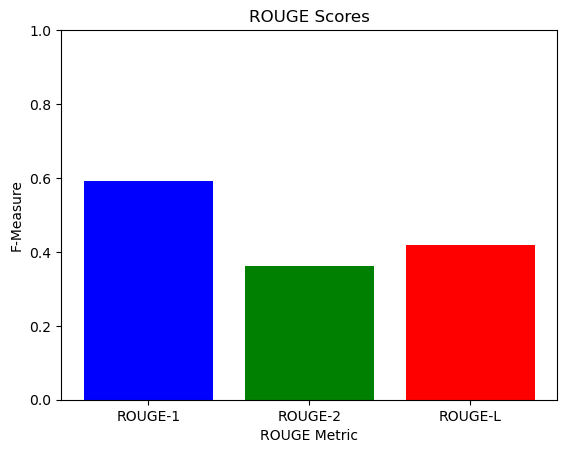

0.5929256401447629 0.3628358947442277 0.41853036497353546


In [22]:
# Plotting the ROUGE scores
def plot_rouge_scores(rouge1, rouge2, rougeL):
    categories = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    scores = [rouge1, rouge2, rougeL]
    
    plt.bar(categories, scores, color=['blue', 'green', 'red'])
    plt.title('ROUGE Scores')
    plt.xlabel('ROUGE Metric')
    plt.ylabel('F-Measure')
    plt.ylim(0, 1)
    plt.show()

plot_rouge_scores(avg_rouge1, avg_rouge2, avg_rougeL)
print(avg_rouge1, avg_rouge2, avg_rougeL)

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rammanyala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
def tokenize(text):
    return nltk.word_tokenize(text.lower())

def evaluate_token_level(generated_summary, reference_summary):
    # Token-level accuracy: matching tokens
    generated_tokens = tokenize(generated_summary)
    reference_tokens = tokenize(reference_summary)
    
    # Calculate precision and recall on token-level matching
    generated_counter = Counter(generated_tokens)
    reference_counter = Counter(reference_tokens)
    
    # True Positives: Matching tokens
    common_tokens = generated_counter & reference_counter
    true_positives = sum(common_tokens.values())
    
    # Precision = TP / (TP + FP) -> how many of the generated tokens match reference tokens
    precision = true_positives / max(1, sum(generated_counter.values()))
    
    # Recall = TP / (TP + FN) -> how many of the reference tokens are matched by generated tokens
    recall = true_positives / max(1, sum(reference_counter.values()))
    
    # F1-Score: Harmonic mean of precision and recall
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0.0
    
    return precision, recall, f1_score



In [25]:
# Calculate Token-Level Evaluation for each row
test_df[['precision', 'recall', 'f1_score']] = test_df.apply(
    lambda row: pd.Series(evaluate_token_level(row['generated_summary'], row['summary'])), axis=1
)

# BLEU score evaluation
def calculate_bleu_score(generated_summary, reference_summary):
    reference_tokens = [tokenize(reference_summary)]
    generated_tokens = tokenize(generated_summary)
    
    # Calculate BLEU score
    bleu_score = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=SmoothingFunction().method2)
    return bleu_score


In [26]:
# Calculate BLEU score for each row
test_df['bleu_score'] = test_df.apply(lambda row: calculate_bleu_score(row['generated_summary'], row['summary']), axis=1)

# Classification Report for Token-Level Evaluation
# print("Classification Report for Token-Level Evaluation (Precision, Recall, F1-Score):")
# test_df[['id', 'precision', 'recall', 'f1_score']]

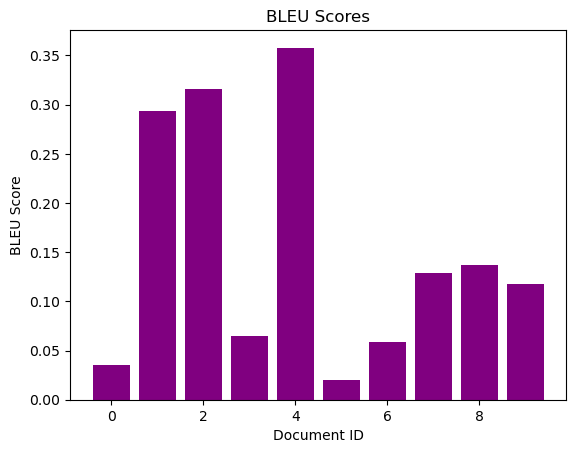

In [27]:
# Plotting the BLEU scores
def plot_bleu_scores(bleu_scores):
    plt.bar(range(len(bleu_scores)), bleu_scores, color='purple')
    plt.title('BLEU Scores')
    plt.xlabel('Document ID')
    plt.ylabel('BLEU Score')
    plt.show()

plot_bleu_scores(test_df['bleu_score'])

In [28]:
# Classification Report on Token-Level Accuracy ---
y_true = [tokenize(summary) for summary in test_df['summary']]
y_pred = [tokenize(gen_summary) for gen_summary in test_df['generated_summary']]

# Flattening token lists for classification report (binary comparison of tokens)
y_true_flat = [token for sublist in y_true for token in sublist]
y_pred_flat = [token for sublist in y_pred for token in sublist]


In [29]:
import fitz  # PyMuPDF for reading PDF

# Function to read text from a PDF file
def read_pdf(file_path):
    doc = fitz.open(file_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

# Function to chunk the text into manageable token sizes (max 1024 tokens)
def chunk_text(text, max_tokens=1024):
    tokens = tokenizer.encode(text)
    chunks = []
    
    # Split the text into chunks based on max_tokens
    for i in range(0, len(tokens), max_tokens - 1):  # Subtract 1 for padding or other special tokens
        chunk = tokens[i:i + max_tokens - 1]  # Ensure each chunk doesn't exceed max_tokens
        chunks.append(tokenizer.decode(chunk, skip_special_tokens=True))
    
    return chunks

# Function to summarize the text chunks
def summarize_document(document):
    inputs = tokenizer(document, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=5, max_length=200, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to summarize a PDF document
def summarize_pdf(file_path, max_tokens=1024):
    # Read and chunk the document
    text = read_pdf(file_path)
    chunks = chunk_text(text, max_tokens)
    
    # Summarize each chunk and combine the summaries
    summaries = [summarize_document(chunk) for chunk in chunks]
    full_summary = ' '.join(summaries)
    
    return full_summary



In [30]:
pdf_file_path = "/Users/rammanyala/Downloads/train-data/test-data/judgement/2727.txt"

# Summarize the PDF
generated_summary = summarize_pdf(pdf_file_path)


Token indices sequence length is longer than the specified maximum sequence length for this model (2180 > 1024). Running this sequence through the model will result in indexing errors


In [31]:
generated_summary

'The appellant \'brought the suit in O.S. No. 3 of 1961 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0in the Court of Subordinate Judge, Nagapattinam for¯¯¯¯setting aside the order dated May 10, 1960 of PsyNetrespondent No. 1 the Commissioner of Hindu Religious¯¯¯¯and Charitable Endowments, Madras who had affirmed \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0earlier the order of the second respondent, the>>\\Deputy Commissioner, holding that the trusteeship of PsyNetthe Kumaran Koil in Manjakollai village was notcffffhereditary.The appellant was elected as a trustee by the PsyNetSengunatha Mudaliars of Manjakuollaivillage at a \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0meeting held on June 27, 1957.The respondents took the matter in appeal to the \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0Madras High Court which by its judgment dated MarchSTDOUT31, 1965 allowed the appeal and set aside the¯¯¯¯¯¯¯¯judgment of the Subordinate judge Nagapattiam. The Judgment of the Court was delivered by The Madras High Court